In [12]:
# import off-the-shelf libraries
import os
import imp
import sys
import GPy, scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time as timemodule
import copy

print '%s\t\t %s' % ('pandas',pd.__version__)
print '%s\t\t %s' % ('numpy', np.__version__)
print '%s\t\t %s' % ('scipy', scipy.__version__)
print '%s\t\t %s' % ('GPy', GPy.__version__)
print '%s\t\t %s' % ('seaborn', sns.__version__)
print '%s\t %s' % ('matplotlib', mpl.__version__)

# set global parameters
%matplotlib inline
sns.set_style('whitegrid')

# import in-house library
sys.path.append("..")
from libs import classical,growth,plates
from libs import growth as growth

pandas		 0.24.2
numpy		 1.16.5
scipy		 1.2.1
GPy		 1.9.9
seaborn		 0.9.0
matplotlib	 2.2.3


***WARNING*** ```BiopythonExperimentalWarning```
<br></br></br> 
```Bio.phenotype``` is an experimental submodule which may undergo significant changes prior to its future official release.

# Read Data

In [13]:
data = pd.read_csv('/Users/firasmidani/rab_fm/proj/biolog/data_20190716/Magellan/PRB954_PM1-1.tsv',
                   sep='\t',header=0,index_col=0);
data.head()

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
A2,0.282,0.281,0.286,0.287,0.294,0.300,0.311,0.327,0.339,0.352,...,0.489,0.484,0.489,0.495,0.491,0.492,0.483,0.488,0.493,0.490
A3,0.275,0.283,0.276,0.288,0.305,0.327,0.355,0.388,0.429,0.470,...,0.535,0.520,0.508,0.495,0.483,0.472,0.461,0.451,0.441,0.433
A4,0.270,0.269,0.272,0.272,0.279,0.286,0.298,0.313,0.327,0.345,...,0.470,0.469,0.469,0.470,0.469,0.471,0.467,0.469,0.472,0.473
A5,0.269,0.268,0.273,0.275,0.284,0.292,0.305,0.323,0.339,0.359,...,0.542,0.540,0.541,0.539,0.538,0.539,0.539,0.539,0.538,0.538


In [14]:
# format 
print type(data.columns[0])

# convert headers from strings to integers
data.columns = plates.listTimePoints(interval=600,numTimePoints=data.shape[1])

data.index.name = 'Well'
data.T.index.name = 'Time'

print type(data.columns[0])

data.head()

<type 'str'>
<type 'numpy.int64'>


Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
A2,0.282,0.281,0.286,0.287,0.294,0.300,0.311,0.327,0.339,0.352,...,0.489,0.484,0.489,0.495,0.491,0.492,0.483,0.488,0.493,0.490
A3,0.275,0.283,0.276,0.288,0.305,0.327,0.355,0.388,0.429,0.470,...,0.535,0.520,0.508,0.495,0.483,0.472,0.461,0.451,0.441,0.433
A4,0.270,0.269,0.272,0.272,0.279,0.286,0.298,0.313,0.327,0.345,...,0.470,0.469,0.469,0.470,0.469,0.471,0.467,0.469,0.472,0.473
A5,0.269,0.268,0.273,0.275,0.284,0.292,0.305,0.323,0.339,0.359,...,0.542,0.540,0.541,0.539,0.538,0.539,0.539,0.539,0.538,0.538


# Read Meta-data

In [15]:
key = plates.initializeBiologPlateKey('PRB954_PM1-1',simple=False);
key.head()

,Plate_ID,Isolate,PM,Replicate,Substrate
Well,,,,,
A1,PRB954_PM1-1,PRB954,1,1,Negative Control
A2,PRB954_PM1-1,PRB954,1,1,L-Arabanose
A3,PRB954_PM1-1,PRB954,1,1,N-Acetyl-D-Glucosamine
A4,PRB954_PM1-1,PRB954,1,1,D-Saccharic Acid
A5,PRB954_PM1-1,PRB954,1,1,Succinic Acid


In [16]:
# remove time points with NaN from data
data = data.iloc[:,np.where(~data.isna().all(0))[0]]
data.head()

Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
A2,0.282,0.281,0.286,0.287,0.294,0.300,0.311,0.327,0.339,0.352,...,0.489,0.484,0.489,0.495,0.491,0.492,0.483,0.488,0.493,0.490
A3,0.275,0.283,0.276,0.288,0.305,0.327,0.355,0.388,0.429,0.470,...,0.535,0.520,0.508,0.495,0.483,0.472,0.461,0.451,0.441,0.433
A4,0.270,0.269,0.272,0.272,0.279,0.286,0.298,0.313,0.327,0.345,...,0.470,0.469,0.469,0.470,0.469,0.471,0.467,0.469,0.472,0.473
A5,0.269,0.268,0.273,0.275,0.284,0.292,0.305,0.323,0.339,0.359,...,0.542,0.540,0.541,0.539,0.538,0.539,0.539,0.539,0.538,0.538


In [17]:
# initialize pd.DataFrame for summarizing data sets
order_columns = ['Well_ID','Letter','Plate_ID','Row','Column']
order_columns += ['Isolate','Substrate','Max_OD','Fold_Change']
order_columns

summary = plates.summarizeGrowthData(data)
summary = summary.join(key)
summary = summary.loc[:,order_columns]
summary.columns = ['Well'] + list(summary.columns[1:])

summary.head()

,Well,Letter,Plate_ID,Row,Column,Isolate,Substrate,Max_OD,Fold_Change
Well,,,,,,,,,
A1,A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000
A2,A2,A,PRB954_PM1-1,1,2,PRB954,L-Arabanose,0.214376,1.000066
A3,A3,A,PRB954_PM1-1,1,3,PRB954,N-Acetyl-D-Glucosamine,0.758015,3.536141
A4,A4,A,PRB954_PM1-1,1,4,PRB954,D-Saccharic Acid,0.210857,0.983649
A5,A5,A,PRB954_PM1-1,1,5,PRB954,Succinic Acid,0.341184,1.591626


In [18]:
# prepare data for growth dynamics inference
data = data.T
data = data.loc[:,key.index]
data = data.reset_index(drop=False);
data.head()

Well,Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,600,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,1200,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,1800,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,2400,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


# Create GrowthPlate object and describe

In [19]:
# define plate object and prepare it for analysis
plate = growth.GrowthPlate(data=data,key=summary,control='A1');

In [20]:
plate.time.head()

,Time
0,0
1,600
2,1200
3,1800
4,2400


In [21]:
plate.data.head()

Well,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,0.265,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,0.260,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,0.265,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,0.270,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,0.273,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


      0      600    1200   1800   2400   3000   3600   4200   4800   5400   \
Well                                                                         
A1    0.277  0.275  0.279  0.280  0.289  0.296  0.310  0.328  0.351  0.362   
A2    0.282  0.281  0.286  0.287  0.294  0.300  0.311  0.327  0.339  0.352   
A3    0.275  0.283  0.276  0.288  0.305  0.327  0.355  0.388  0.429  0.470   
A4    0.270  0.269  0.272  0.272  0.279  0.286  0.298  0.313  0.327  0.345   
A5    0.269  0.268  0.273  0.275  0.284  0.292  0.305  0.323  0.339  0.359   

      ...  54000  54600  55200  55800  56400  57000  57600  58200  58800  \
Well  ...                                                                  
A1    ...  0.478  0.473  0.476  0.477  0.474  0.476  0.471  0.474  0.476   
A2    ...  0.489  0.484  0.489  0.495  0.491  0.492  0.483  0.488  0.493   
A3    ...  0.535  0.520  0.508  0.495  0.483  0.472  0.461  0.451  0.441   
A4    ...  0.470  0.469  0.469  0.470  0.469  0.471  0.467  0.469  0.472 

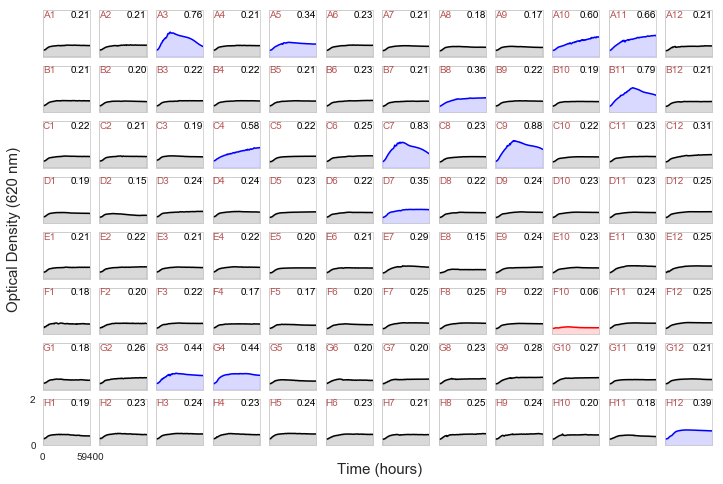

In [22]:
fig,ax = plate.plot();
fig

# Create GrowthData object and describe

In [23]:
plate.mods

smoothed      False
floored       False
controlled    False
logged        False
dtype: bool

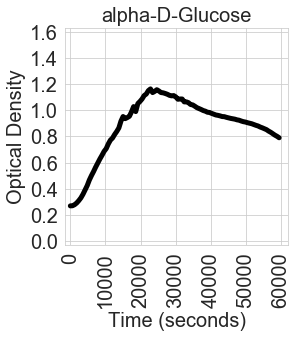

In [24]:
fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-1500,62000])

[ii.set(rotation=90) for ii in ax.get_xticklabels()];

ax.set_xlabel('Time (seconds)');

In [25]:
plate.mods

smoothed      False
floored       False
controlled    False
logged        False
dtype: bool

## Conver Time to minutes

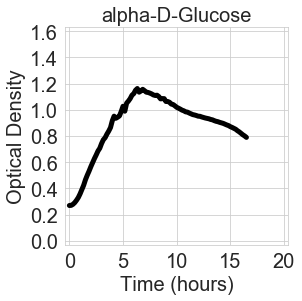

In [26]:
plate.convertTimeUnits()

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

ax.set_xlabel('Time (hours)');

In [27]:
plate.mods

smoothed      False
floored       False
controlled    False
logged        False
dtype: bool

## Smooth OD data

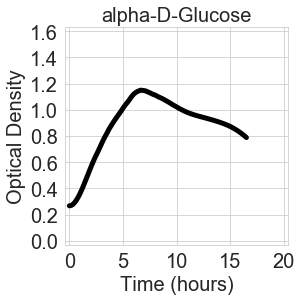

In [28]:
plate.smoothData();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

ax.set_xlabel('Time (hours)');

In [29]:
plate.mods

smoothed       True
floored       False
controlled    False
logged        False
dtype: bool

## Transform with natural logarithm

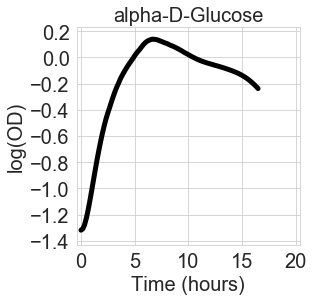

In [30]:
plate.logData();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-1.43,0.23])
ax.set_xlim([-0.4,20.4])

ax.set_xlabel('Time (hours)');

In [31]:
plate.mods

smoothed       True
floored       False
controlled    False
logged         True
dtype: bool

## Scale OD to the first time point log(OD)=0 <--> OD=1

(-0.4, 20.4)

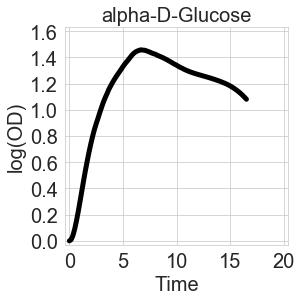

In [32]:
plate.subtractBaseline();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

In [33]:
plate.mods

smoothed       True
floored        True
controlled    False
logged         True
dtype: bool

## Subtract negative control OD at each time point

(-0.4, 20.4)

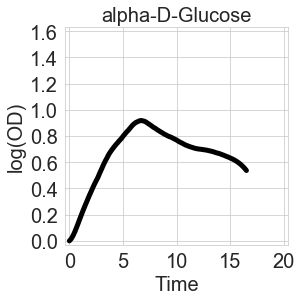

In [34]:
plate.subtractControl();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

In [35]:
plate.mods

smoothed      True
floored       True
controlled    True
logged        True
dtype: bool

## Fit growth curves with classical approach of Gompertz

In [36]:
import imp
imp.reload(growth)

<module 'libs.growth' from '../libs/growth.py'>

 /Users/firasmidani/.conda/envs/RABPY/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning:Covariance of the parameters could not be estimated


Doubling Rate is 150.61 minutes


,Well,Letter,Plate_ID,Row,Column,Isolate,Substrate,Max_OD,Fold_Change,classical_r,classical_K,classical_d,classical_AUC,classical_td,classical_max
Well,,,,,,,,,,,,,,,
C9,C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.276134,0.702891,0.770356,10.826688,150.611298,0.750585


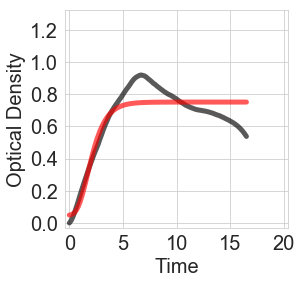

In [37]:

glucose = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']})

gompertz = growth.GrowthMetrics(glucose);
gompertz.fitClassical(classical.gompertz)
gompertz.inferClassicalDynamics()
gompertz.predictClassical()

fig,ax = gompertz.plot();

ax.set_ylim([-0.03,1.32])
ax.set_xlim([-0.4,20.4])

print 'Doubling Rate is %0.2f minutes' % gompertz.key['classical_td']

gompertz.key

## Fit growth curve with non-parameteric GP Regression approach

Doubling Rate is 190.61 minutes


 ../libs/growth.py:727: RuntimeWarning:invalid value encountered in sqrt


,Well,Letter,Plate_ID,Row,Column,Isolate,Substrate,Max_OD,Fold_Change,GP_r,GP_K,GP_d,GP_AUC,GP_td,GP_max
Well,,,,,,,,,,,,,,,
C9,C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.218193,0.917325,0.0,10.871468,190.605635,0.917325


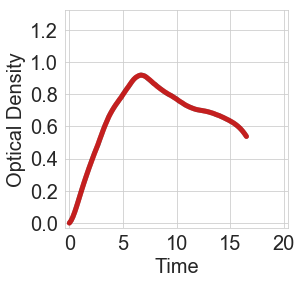

In [38]:
glucose = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']})

gpr = growth.GrowthMetrics(glucose);
gpr.fitGP()
gpr.inferGPDynamics()
gpr.predictGP()

fig,ax = gpr.plot();

ax.set_ylim([-0.03,1.32])
ax.set_xlim([-0.4,20.4])

print 'Doubling Rate is %0.2f minutes' % gpr.key['GP_td']

gpr.key

# Summarize dynamics in all wells of the plate

In [39]:
# initialize pd.DataFrame to store summary metrics/statistics
growth_summary = pd.DataFrame(index=summary.index,
                              columns=['GP_r','GP_K','GP_AUC','GP_td',
                                       'classical_r','classical_K','classical_AUC','classical_td']);
growth_summary.head()

,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    od = plate.extractGrowthData({'Substrate':[substrate]}); # control is not subtracted
    
    cls = growth.GrowthMetrics(od)
    cls.fitClassical(classical.gompertz)
    cls.inferClassicalDynamics()

    to_header = ['classical_r','classical_K','classical_AUC','classical_td'];
    to_index = cls.key.index[0]
    growth_summary.loc[to_index,to_header] = cls.key.loc[to_index,to_header].values

    gpr = growth.GrowthMetrics(od)
    gpr.fitGP()
    gpr.inferGPDynamics()

    to_header = ['GP_r','GP_K','GP_AUC','GP_td'];
    to_index = gpr.key.index[0]
    growth_summary.loc[to_index,to_header] = gpr.key.loc[to_index,to_header].values


01 .

 ../libs/classical.py:100: RuntimeWarning:divide by zero encountered in double_scalars
 ../libs/classical.py:100: RuntimeWarning:invalid value encountered in multiply
 ../libs/classical.py:100: RuntimeWarning:invalid value encountered in double_scalars


 . . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . . . . . 
04 . . . . . . . . . .

 /Users/firasmidani/.conda/envs/RABPY/lib/python2.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/firasmidani/.conda/envs/RABPY/lib/python2.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/firasmidani/.conda/envs/RABPY/lib/python2.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . . . . .


In [42]:
summary_df = summary.join(growth_summary).sort_values(['GP_td'],ascending=True)
summary_df.head(10)

,Well,Letter,Plate_ID,Row,Column,Isolate,Substrate,Max_OD,Fold_Change,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,,,,,,,,,,
A3,A3,A,PRB954_PM1-1,1,3,PRB954,N-Acetyl-D-Glucosamine,0.758015,3.536141,0.285946,0.763807,7.16737,145.443,62.2095,-0.462551,7.17666,0.668529
H5,H5,H,PRB954_PM1-1,8,5,PRB954,D-Psicose,0.243431,1.135607,0.284019,0.136797,1.56914,146.43,-0.0331854,0.0396147,1.56319,-1253.23
C7,C7,C,PRB954_PM1-1,3,7,PRB954,D-Fructose,0.825154,3.849344,0.235521,0.899295,10.1327,176.582,0.30617,0.644048,10.1089,135.836
C9,C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.218193,0.917325,10.8715,190.606,0.276134,0.702891,10.8267,150.611
G4,G4,G,PRB954_PM1-1,7,4,PRB954,L-Threonine,0.440850,2.056564,0.172972,0.415119,5.35975,240.436,0.186328,0.41268,5.33326,223.202
H12,H12,H,PRB954_PM1-1,8,12,PRB954,2-Aminoethanol,0.387359,1.807031,0.163044,0.362182,4.45912,255.078,0.197788,0.309303,4.43422,210.27
F10,F10,F,PRB954_PM1-1,6,10,PRB954,Glyoxylic Acid,0.062088,0.289641,0.153532,0.0232271,-5.73861,270.88,NaN,NaN,-5.70294,NaN
B11,B11,B,PRB954_PM1-1,2,11,PRB954,D-Mannitol,0.792709,3.697988,0.153035,0.871126,9.91157,271.761,0.189058,0.693589,9.86597,219.98
G6,G6,G,PRB954_PM1-1,7,6,PRB954,L-Alanyl-Glycine,0.200206,0.933962,0.152304,0.0472129,-0.784114,273.065,NaN,NaN,-0.775738,NaN


# Analyze growth metrics across plate  (example)

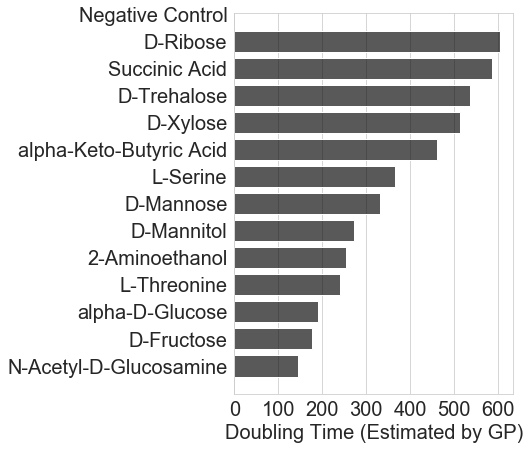

In [46]:
fig,ax = plt.subplots(figsize=[5,7]);

# grab all growth curves with at least 1.5 fold change (relative to negative control)
subset = list(summary_df[summary_df['Fold_Change']>1.5].Substrate.values)+list(['Negative Control']);

labels = summary_df[summary_df.isin({'Substrate':subset}).any(1)].Substrate
td = summary_df[summary_df.isin({'Substrate':subset}).any(1)].GP_td;

ax.barh(y=range(len(labels)),width=td,height=0.8,color=(0,0,0,0.65));

[ii.set(fontsize=20) for ii in ax.get_xticklabels()+ax.get_yticklabels()];

ax.set_xlabel('Doubling Time (Estimated by GP)',fontsize=20);
plt.setp(ax,yticks=range(len(labels)),yticklabels=labels);
ax.yaxis.grid(False)

In [47]:
plate.mods

smoothed      True
floored       True
controlled    True
logged        True
dtype: bool

      0.000000   0.166667   0.333333   0.500000   0.666667   0.833333   \
Well                                                                     
A1          0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
A2          0.0   0.003773   0.003447  -0.000281  -0.006560  -0.014509   
A3          0.0  -0.020878  -0.021444  -0.004005   0.027237   0.067547   
A4          0.0  -0.007586  -0.014140  -0.019488  -0.023587  -0.026507   
A5          0.0  -0.001974  -0.002871  -0.002617  -0.001229   0.001217   

      1.000000   1.166667   1.333333   1.500000   ...  15.000000  15.166667  \
Well                                              ...                         
A1     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
A2    -0.023318  -0.032293  -0.040877  -0.048639  ...   0.004403   0.005750   
A3     0.112689   0.159411   0.205505   0.249636  ...   0.093489   0.069235   
A4    -0.028386  -0.029398  -0.029720  -0.029517  ...   0.000215   0.001050   
A5     

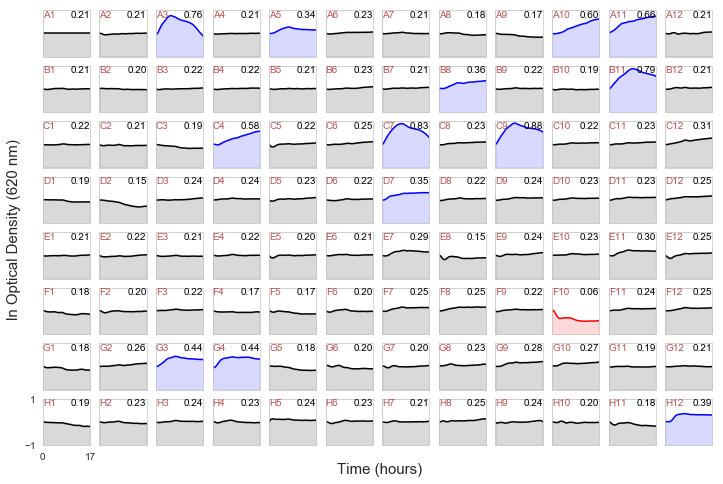

In [48]:
fig,ax = plate.plot();
fig

## Would this be different if you do not subtract negative control (no carbon) growth?

In [49]:
# define plate object and prepare it for analysis
plate = growth.GrowthPlate(data=data,key=summary,control='A1');

In [50]:
plate.convertTimeUnits()
plate.smoothData()
plate.logData()
plate.subtractBaseline()

plate.mods

smoothed       True
floored        True
controlled    False
logged         True
dtype: bool

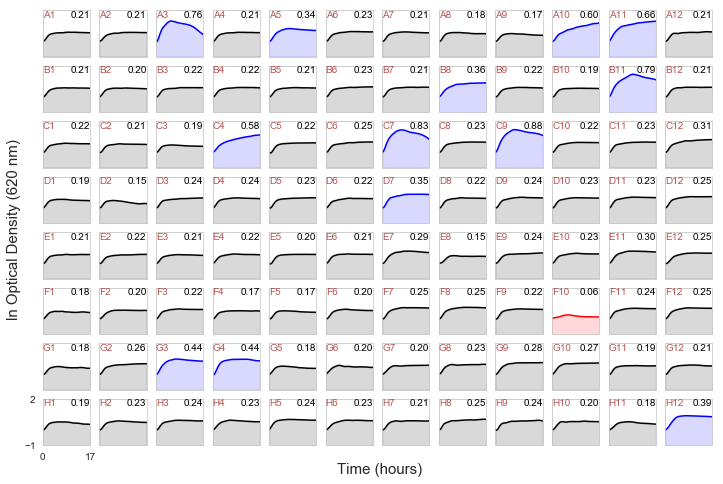

In [51]:
fig,ax = plate.plot(); fig

In [52]:
# initialize pd.DataFrame to store summary metrics/statistics
growth_summary = pd.DataFrame(index=summary.index,
                              columns=['GP_r','GP_K','GP_AUC','GP_td',
                                       'classical_r','classical_K','classical_AUC','classical_td']);
growth_summary.head()

,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    od = plate.extractGrowthData({'Substrate':[substrate]}); # control is not subtracted
    
    cls = growth.GrowthMetrics(od)
    cls.fitClassical(classical.gompertz)
    cls.inferClassicalDynamics()

    to_header = ['classical_r','classical_K','classical_AUC','classical_td'];
    to_index = cls.key.index[0]
    growth_summary.loc[to_index,to_header] = cls.key.loc[to_index,to_header].values

    gpr = growth.GrowthMetrics(od)
    gpr.fitGP()
    gpr.inferGPDynamics()

    to_header = ['GP_r','GP_K','GP_AUC','GP_td'];
    to_index = gpr.key.index[0]
    growth_summary.loc[to_index,to_header] = gpr.key.loc[to_index,to_header].values

 01 . . . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . . . . . 
04 . . . . . . . . . . . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . .

In [ ]:
summary_df = summary.join(growth_summary).sort_values(['GP_td'],ascending=True)
summary_df.head(10)

In [ ]:
fig,ax = plt.subplots(figsize=[5,7]);

# grab all growth curves with at least 1.5 fold change (relative to negative control)
subset = list(summary_df[summary_df['Fold_Change']>1.5].Substrate.values)+list(['Negative Control']);

labels = summary_df[summary_df.isin({'Substrate':subset}).any(1)].Substrate
td = summary_df[summary_df.isin({'Substrate':subset}).any(1)].GP_td;

ax.barh(y=range(len(labels)),width=td,height=0.8,color=(0,0,0,0.65));

[ii.set(fontsize=20) for ii in ax.get_xticklabels()+ax.get_yticklabels()];

ax.set_xlabel('Doubling Time (Estimated by GP)',fontsize=20);
plt.setp(ax,yticks=range(len(labels)),yticklabels=labels);
ax.yaxis.grid(False)